In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    vol_window = 30
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    for idx in range(0,cut_off+pred_len , pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 1))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 1))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label

        # Plot the predictions
        plt.plot(np.arange(idx, idx + pred_len), future_transform, 
                # label="Train Prediction" if idx < cut_off else "Test Prediction", 
                 color="red" if idx < cut_off else "blue")

        # Plot the true values
        plt.plot(np.arange(idx, idx + pred_len), future_true_transform, 
                 #label="Train True" if idx < cut_off else "Test True", 
                 color="black" if idx < cut_off else "green")

        
    
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    for i, rmse in zip(section_start_idx, rmse_values):
        plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    plt.text(- 5- pred_len / 2, min(plt.ylim()), f"MAPE:", color="teal", fontsize=10, ha='center', va='top')
    print(rmse_values)
    plt.grid(True)
    if m == "NN w/ 1 feature":
        dir = f"{seq_len}-{pred_len}/nn_1"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "NN w/ 1 feature"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2021-01-01", end_date="2024-09-30")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        # tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close']#, 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # # Step 5: Perform Hankel Matrix Decomposition
        # window_size = 50  # Size of the sliding window to form the Hankel matrix
        # hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # # Step 6: Perform SVD on the Hankel matrix
        # U, Sigma, Vt = hankel_svd(hankel_matrix)

        # # You can choose the first few singular values and modes to add as features
        # num_modes = 2  # Number of modes to add as features
        # dmd_modes = U[:, :num_modes]  # Select the modes
        # dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # # Trim the processed_data to match the number of rows in dmd_modes
        # processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # # Combine the Hankel decomposition modes with the processed data
        # data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 6 * 30  # 6 months of data
        pred_len = 20  # Predict the next 20 days
        sequences = create_sequences(processed_data, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.95 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, processed_data, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0626 
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0168
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0078
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 16/100

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0481
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5577e-04
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 16/10

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0843
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 16/100


[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0788
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 16/100
20

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1048  
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0202
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067
Epoch 16/100
2

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1025  
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099
Epoch 16/100
2

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0767 
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 16/100
20

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0821
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0165
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0159
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 16/100

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0762
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060
Epoch 16/100
2

[*********************100%***********************]  1 of 1 completed

(642, 200, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0664
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 16/100
20/

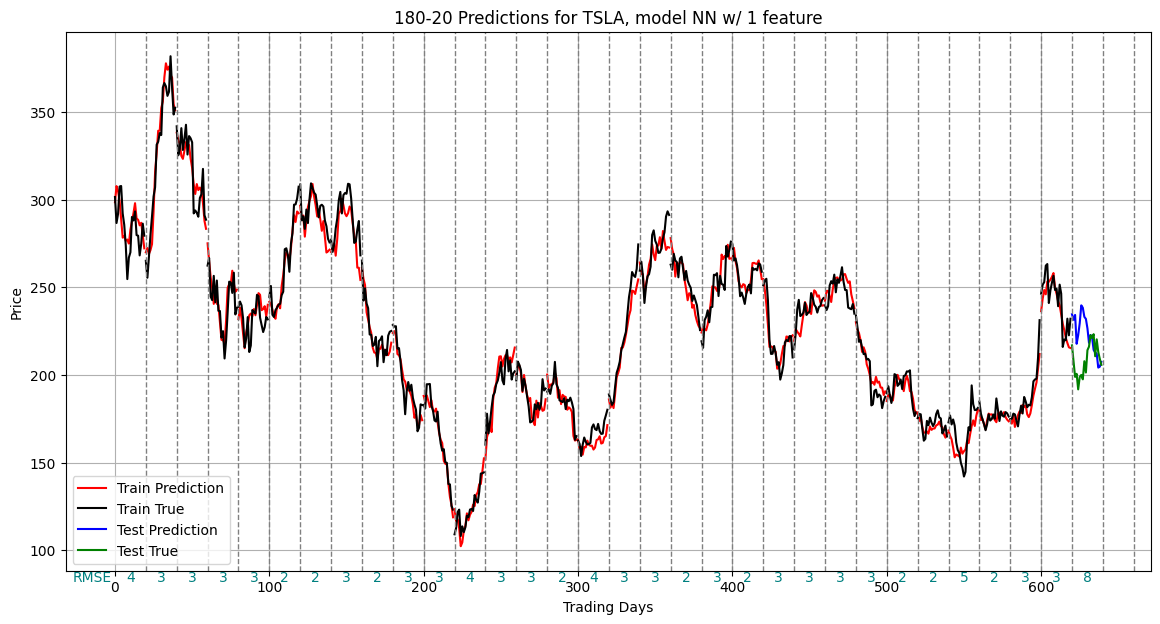

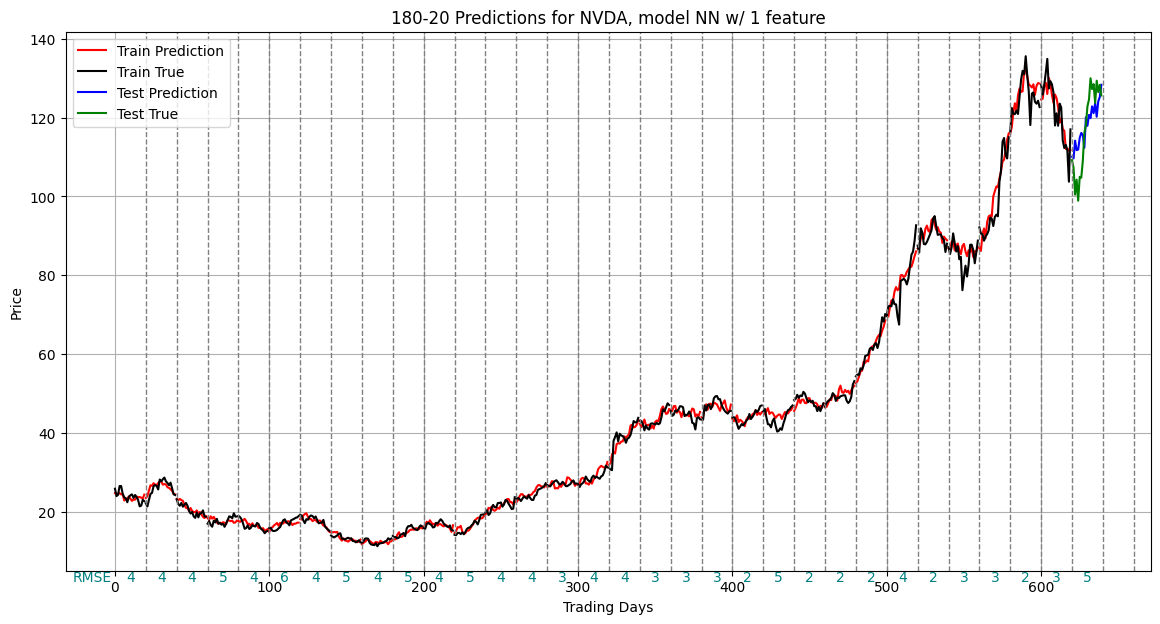

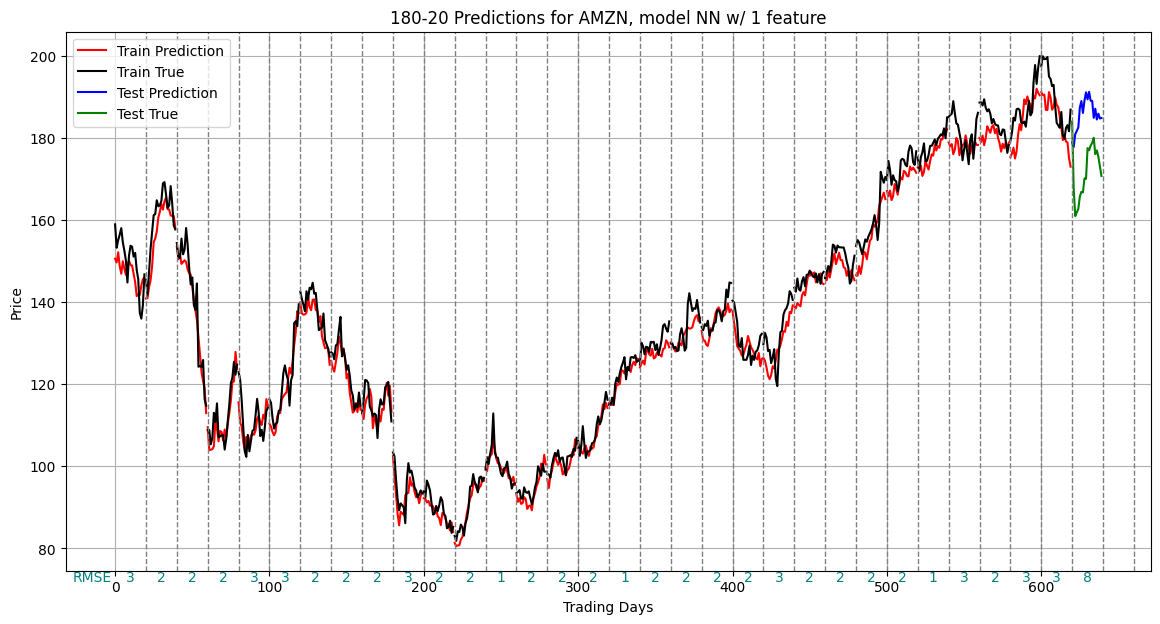

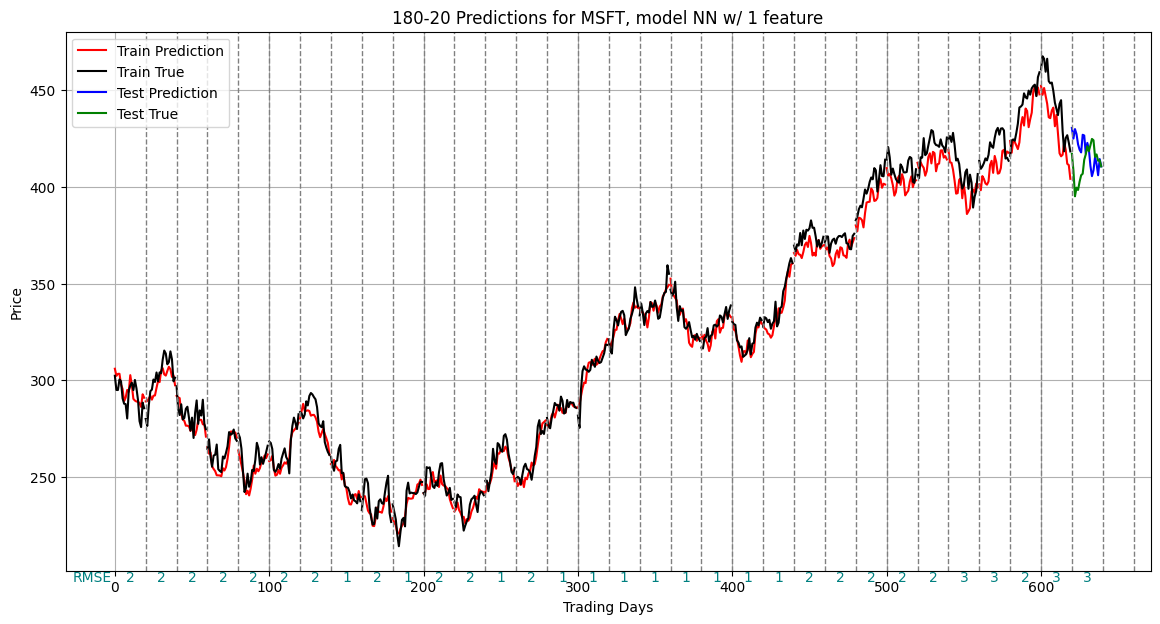

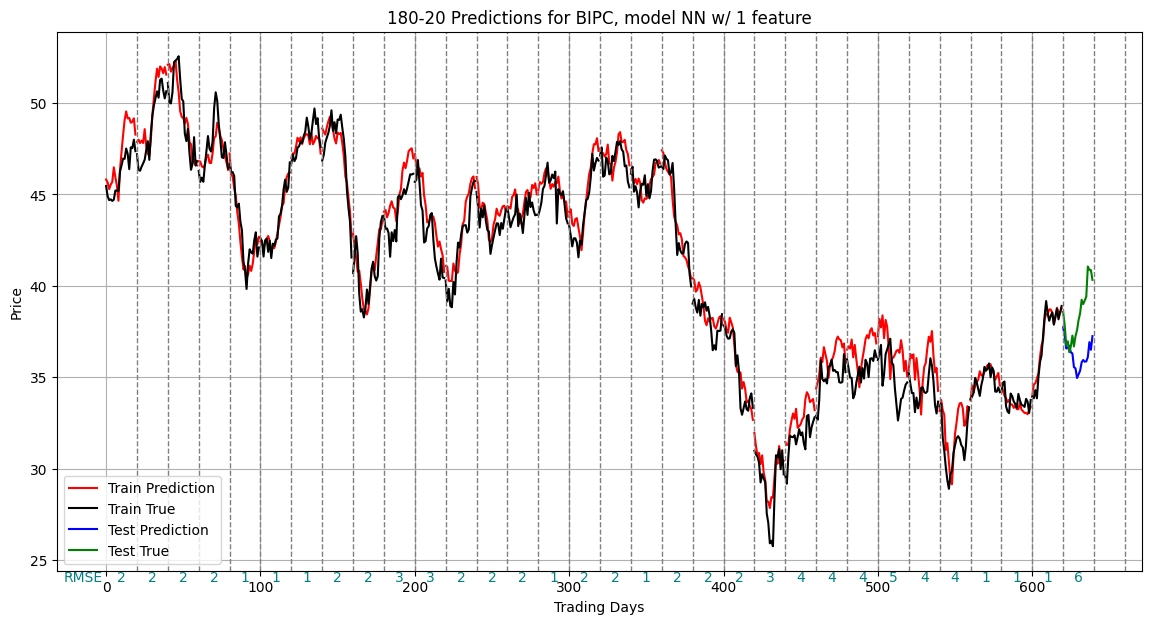

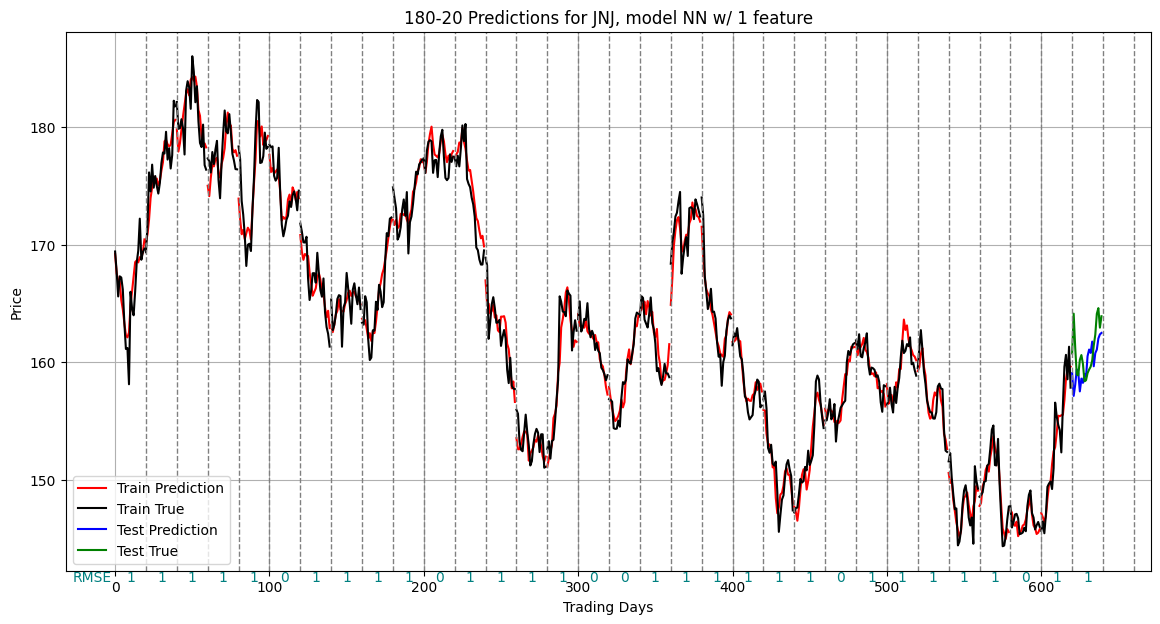

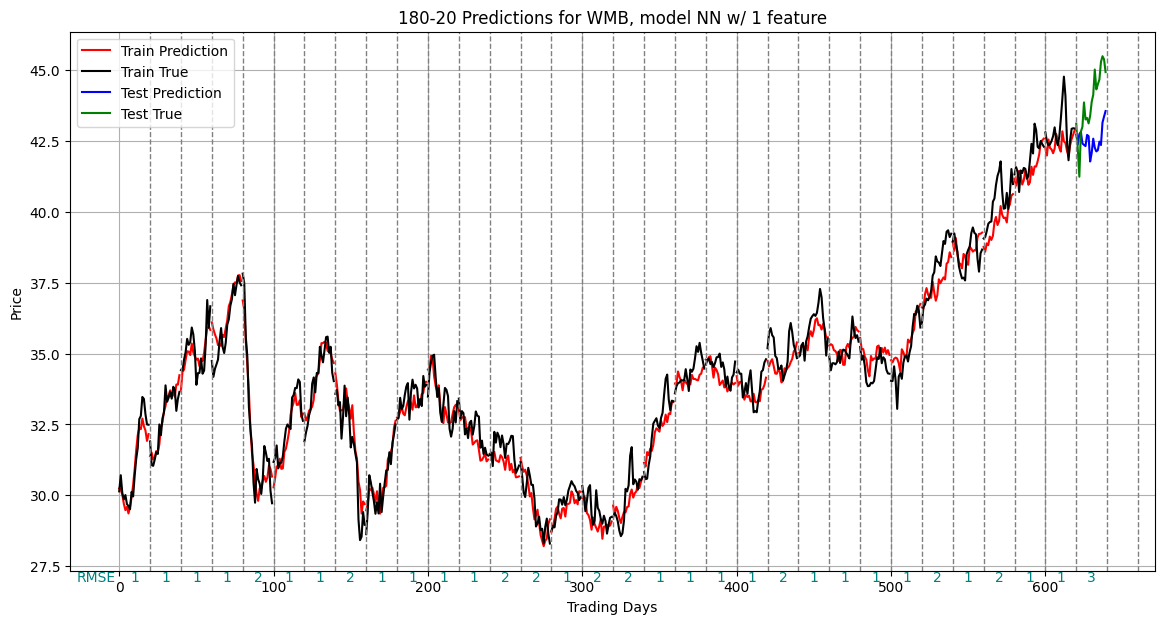

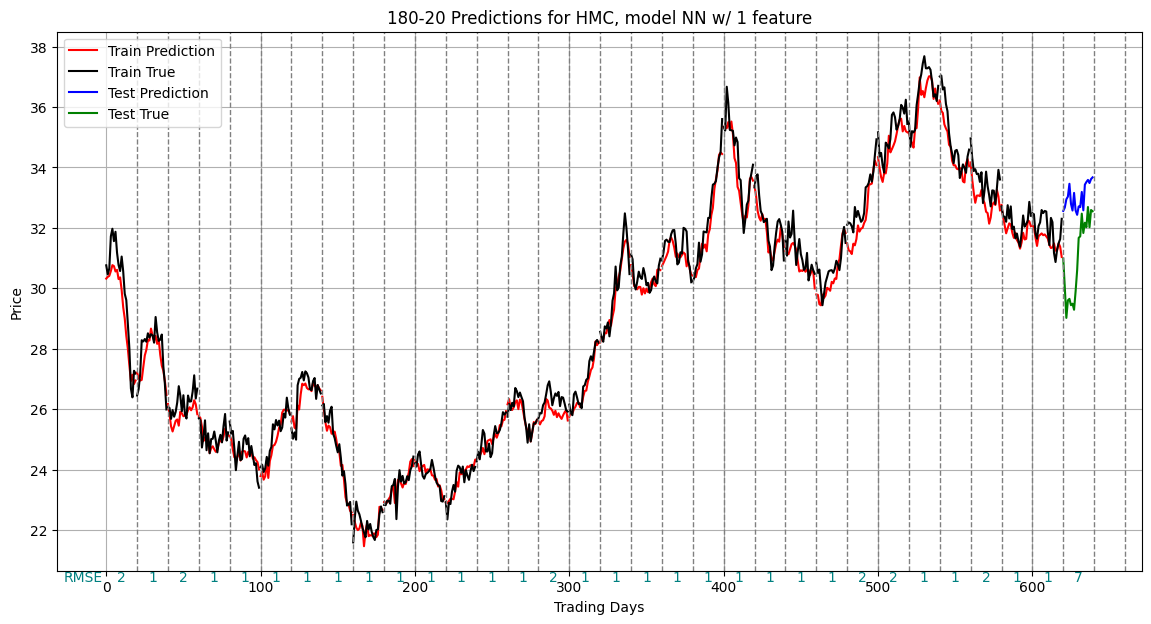

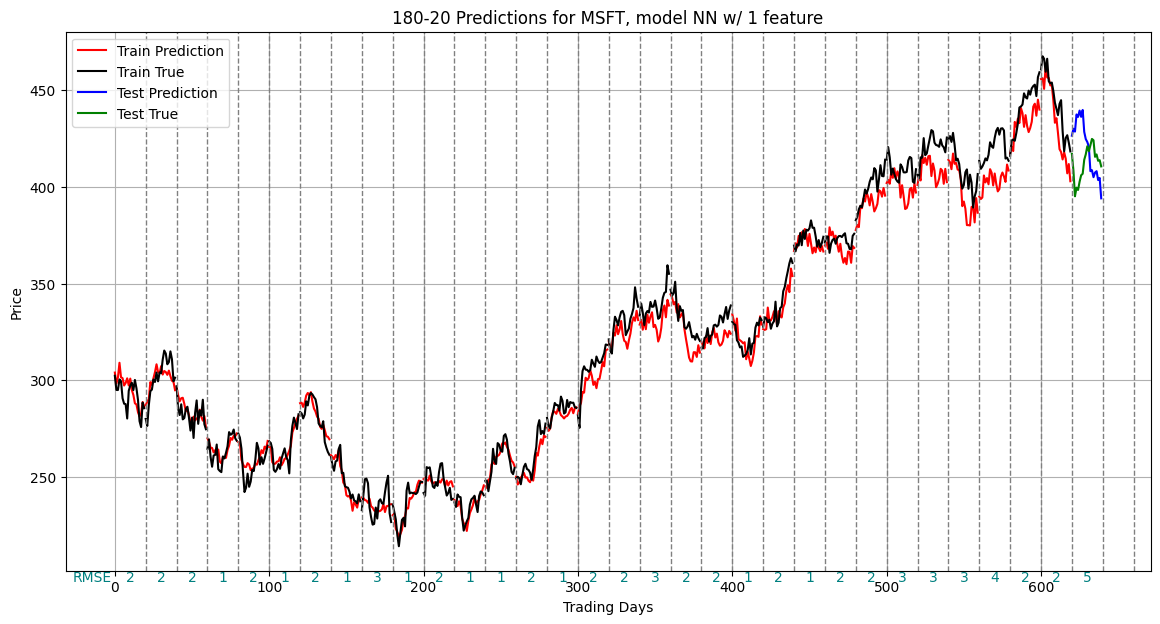

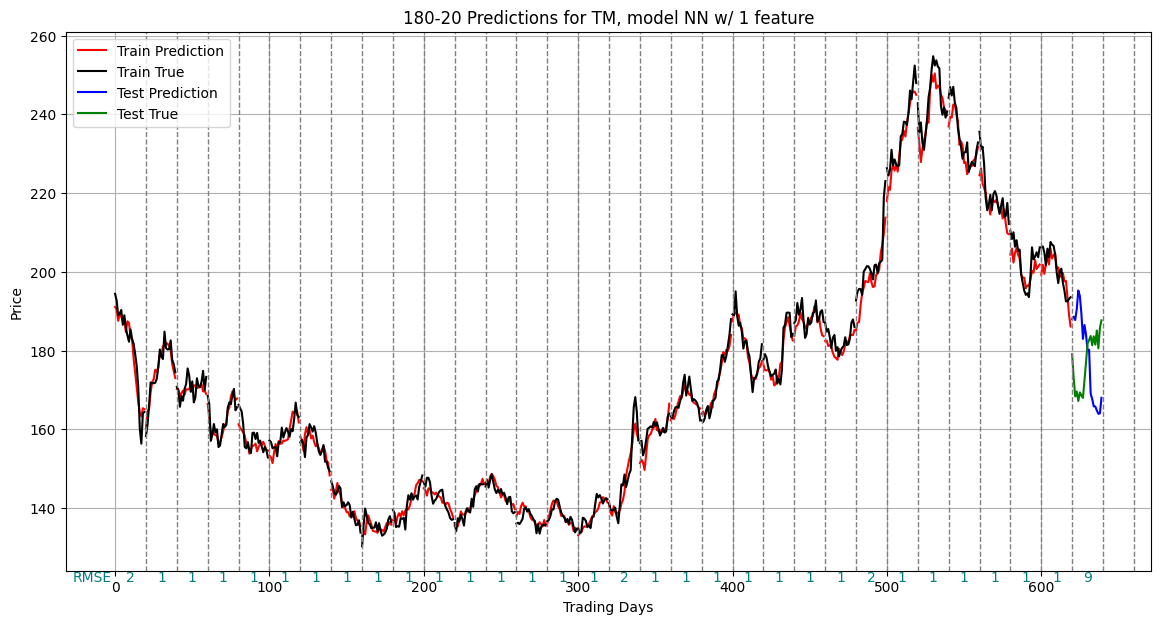

In [5]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [6]:
mse

5.551965322142013